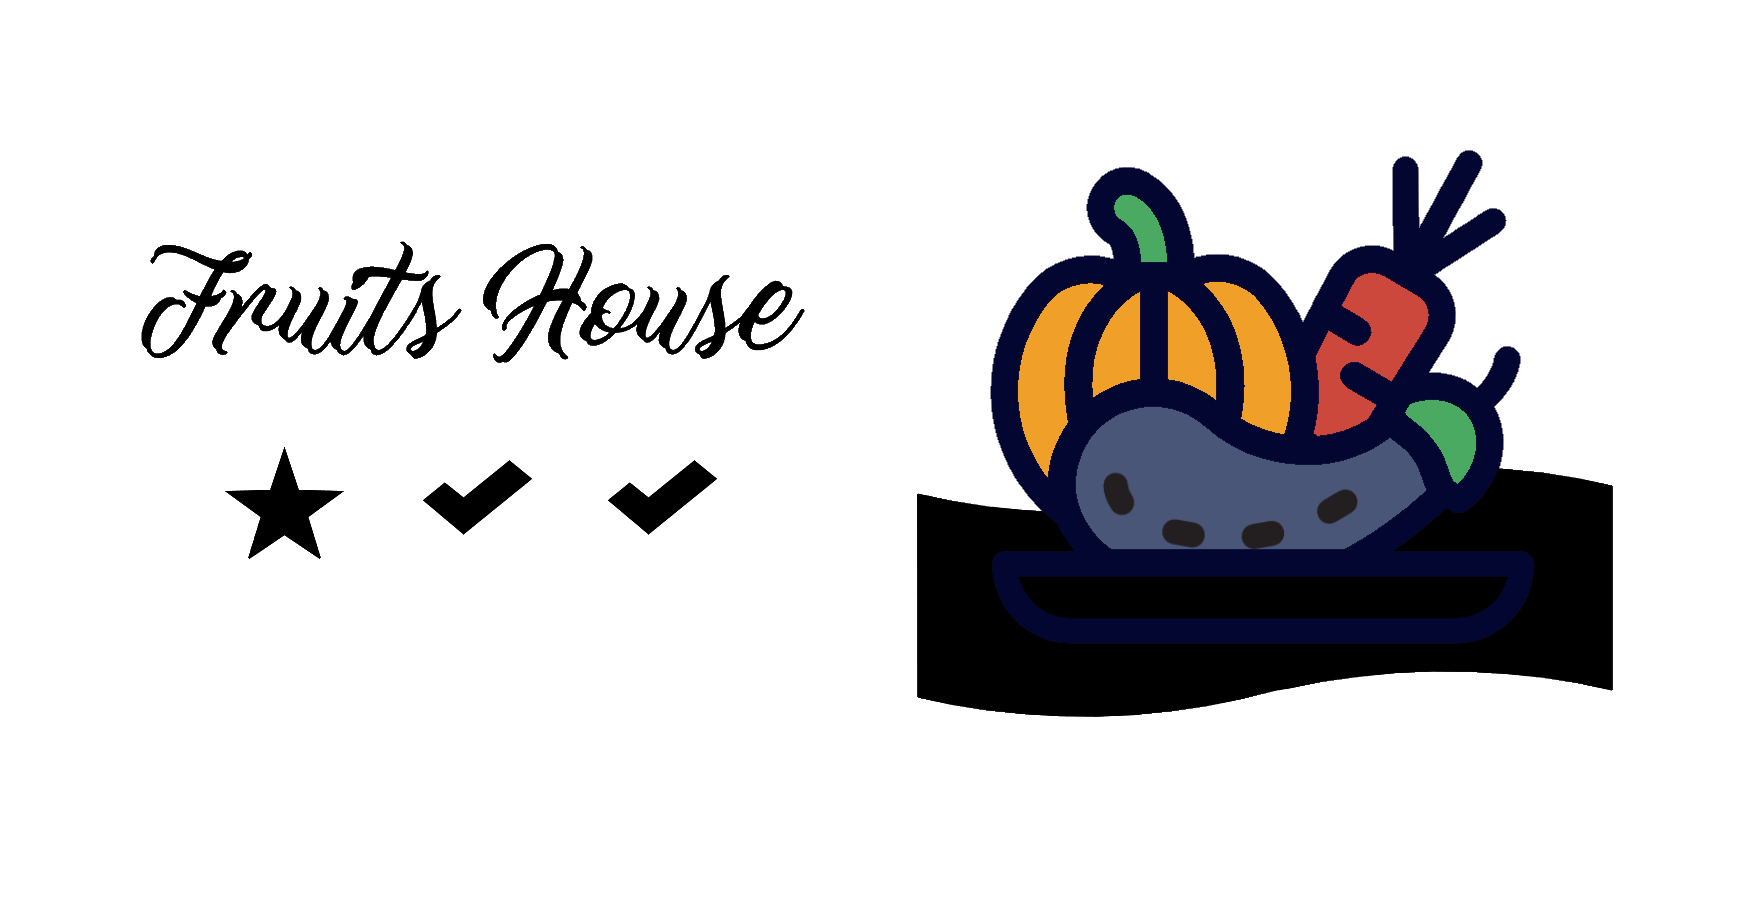

In [4]:
Image( '../img/f_r.png' )

**Problema de Negócio**<br>
Casa das Frutas é uma agroindústria no sul do Brasil que recentemente iniciou grandes expansões, principalmente na área da tecnologia, e uma das novas ideias foi desenvolver um novo método de coleta e classificação de frutas utilizando o auxílio da A.I.
O time de dados foi desafiado a responder a seguinte pergunta:
1. Como vou classificar frutas sem a supervisão Humana?

**Modelo de Negócio & Algumas Métricas**<br>
Algumas etapas do Modelo de Negócio de uma empresa desse ramo:

1. **Plantações de Frutas:**
O campo de plantação da Casa das Frutas é significativamente extenso, tendo *n* km onde a plantação de diversas frutas e verduras são realizadas em diferentes quadrantes do terreno.
        - Redução de tempo de checagem das plantações.

2. **Coleta de Frutas:**
Nas plantações, geralmente é aberto vagas onde várias pessoas focam seu trabalho na coleta dessas frutas e legumes, como exemplo na coleta de maçãs de macieiras plantadas enfileiradas, onde cada indivíduo ou grupo trabalha em uma fileira dessas arvores realizando assim a coleta dessa fruta, é possível uma coleta completa por ano dependendo da fruta ou do vegetal e suas características. Existem frutas onde a coleta anual é realizada e outras só depois de 2 a 3 anos após a plantação.
        - Redução de custo de Mão de Obra.

3. **Preparação das Frutas:**
Após a chegada da fruta / verdura na empresa especializada, a fruta é passada por vários passos, como pré seleção, checagem de qualidade, resfriador, entre outros passos, cada fruta tem uma forma de ser processada, como frutas congeladas para doces e sucos, frutas secas para cereais e tortas, frutas cortadas para *n* finalidades.
        - Redução de tempo de Preparo.

4. **Fruits Storange:**
Essa etapa é muito importante, pois é um passo antes de ser enviada ao consumidor, nessa etapa é utilizado muita tecnologia para armazenar as frutas em um local correto, como exemplo as frutas congeladas ou derivados já preparados pela empresa Casas das Frutas.

5. **Fruits Transportation:**
Basicamente como que as frutas e verduras são vendidas em todo o Brasil.

**Suposições e Perguntas**

1. Qual é Tamanho do Terreno para realizar o plantio dessas frutas e verduras ?
2. Qual fruta / verdura gera maior lucro para a empresa ?
3. Qual os esforços necessários para que essa melhor fruta / verdura seja enviada ao mercado ?
4. Qual a qualidade da coleta das frutas por essas pessoas contratadas ?
5. Qual a qualidade dos equipamentos que essas pessoas utilizam para realizar a coleta dessas frutas ?
6. Qual a avaliação das frutas / verduras pelos consumidores no mercado ?

## Documentação Resumo

**Preparação dos Dados**
Nessa etapa foi utilizado o conceito de Data Augmentation para aumentar a quantidade de exemplos de imagens no dataset que foi automaticamente carregado com a função flow_from_directory que separa os labels e o conjunto de treinamento.

**Redes Neurais Convolucionais**
Foi utilizado uma arquitetura que eu desenhei no papel que está no README.md, e outra arquitetura mais robusta que foi selecionada para o Deployment.

**O que é uma CNN ?** 
CNN é uma variação das MLP, usado para classificação de imagens, detecção de objetos e transferência de estilo de imagens.
Existem muitas técnicas únicas com objetivos específicos em cada camada da rede.
Conv2d é responsavel pela camada de convolução da rede (Detectar Cantos, etc), MaxPooling funcina como redutor de dimensionalidade dado que uma img é uma matrix de pixels $N_w x N_h x N_c$, Dropout reduz as unidades durante o treinamento para diminuir a chance de overfitting da rede, Stride é o passo da convolução, Padding é uma nova linhas de pixel na imagem, geralmente utilizado quando a rede é pequena*, e muitas outras características.

**Deployment**
Como o objetivo era o Modelo mesmo para a classificação, então foi enviado o modelo com uma aplicação extra na nuvem, onde o usuário envia sua imagem a aplicação e o mesmo modelo classifica essa imagem retornando um dataframe de probabilidades de pertencer a determinada fruta ou verdura a imagem que o usuário enviou.

**Material Suplementar**<br>
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7174504/
- https://www.fao.org/es/faodef/fdef08e.htm
- https://www.tensorflow.org/api_docs/python/tf/image/resize

## 0.1. Imports

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from pandas import DataFrame
from IPython.display import Image

## 0.2. Aux Functions

In [135]:
def extract_label( list_ ):
    return list_.split('/')[-2]

def plot_nn_performace( title ):
    fig, ax = plt.subplots( figsize=(5, 4) )
    ax.plot( history.history['loss'], label='Loss', color='k' )
    ax.plot( history.history['val_loss'], label='Val Loss', color='r' )
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epochs')
    ax.legend();
    
def new_image( img_path ):
    image = tf.io.read_file( img_path )
    image = tf.io.decode_jpeg( image )
    image = tf.image.resize( image, [100, 100], method='bilinear' )
    plt.imshow( image.numpy() / 100 )
    image = tf.expand_dims( image, 0 );
    
    return image

def model_predict( img_path, model ):
    img  = new_image( img_path )
    prev = model.predict( img )

    percentages = [prev[0][i] for i in range( 0, 24, 1 )]

    percentage_dict = { 'Labels': sorted( set( unique_labels ) ), 'Percentages': percentages }    
    dataframe = DataFrame( percentage_dict )
    dataframe = dataframe[dataframe['Percentages'] > .20]
    dataframe = dataframe.reset_index(drop=True)

    if dataframe.empty:
        print('I dont know what is that ;-;')
        
    return dataframe

# 1.0. Load Img Dataset

In [7]:
train_path = Path( '../fruits-360/Training/' )
valid_path = Path( '../fruits-360/Validation/' )
test_path  = Path( '../fruits-360/Test/' )

img_train = [p.replace('\\', '/') for p in list( map( lambda x: str(x), list(train_path.glob('*/*') ) ) )]
img_valid = [p.replace('\\', '/') for p in list( map( lambda x: str(x), list( valid_path.glob('*/*') ) ) )]
img_test  = [p.replace('\\', '/') for p in list( map( lambda x: str(x), list( valid_path.glob('*/*') ) ) )]

unique_labels = set( [extract_label(p) for p in img_train] )
train_labels  = np.array( [extract_label(p) for p in img_train] )
valid_labels  = np.array( [extract_label(p) for p in img_valid] )
test_labels   = np.array( [extract_label(p) for p in img_test] )

print(f'Unique Fruits: {len(unique_labels)}\nFruits for Training: {len(train_labels)}\nFruits for Validation: {len(valid_labels)}\nFruits for Test: {len(test_labels)}')

Unique Fruits: 24
Fruits for Training: 6231
Fruits for Validation: 3114
Fruits for Test: 3114


# 2.0. Img Dataset Augmentation & Pre-processing

Data Augemntation with Keras
Documentation: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [5]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            zoom_range=.15,
            width_shift_range=.2,
            height_shift_range=.2,
            horizontal_flip=True,
            shear_range=.15,
            rotation_range=.30 )

datagen_test = tf.keras.preprocessing.image.ImageDataGenerator()

In [8]:
train_img = datagen.flow_from_directory( train_path, 
                                         target_size = (100, 100),
                                         batch_size  = 32,
                                         color_mode  = 'rgb',
                                         class_mode  = 'categorical',
                                         shuffle = True )

valid_img = datagen.flow_from_directory( valid_path,
                                         target_size = (100, 100),
                                         batch_size  = 32,
                                         color_mode  = 'rgb',
                                         class_mode  = 'categorical',
                                         shuffle = True )

test_img = datagen_test.flow_from_directory( test_path,
                                             target_size = (100, 100),
                                             batch_size  = 32,
                                             color_mode = 'rgb',
                                             class_mode = 'categorical',
                                             shuffle = False ) 

Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.
Found 3110 images belonging to 24 classes.


# 3.0. CNN Model Definition

## 3.1. One Convolutional NN Definition

In [134]:
# Model Definition
cnn = tf.keras.models.Sequential()

cnn.add( tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
cnn.add( tf.keras.layers.MaxPooling2D( pool_size=(2, 2) ) )
cnn.add( tf.keras.layers.Dropout(.2) )
cnn.add( tf.keras.layers.Flatten())

cnn.add( tf.keras.layers.Dense(128, activation='relu' ) )
cnn.add( tf.keras.layers.Dense(24, activation='softmax') )

# Model Compile
cnn.compile( loss = tf.keras.losses.categorical_crossentropy,
             metrics   = ['accuracy'],
             optimizer = tf.keras.optimizers.Adam() )

In [135]:
cnn.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 flatten_4 (Flatten)         (None, 394272)            0         
                                                                 
 dense_8 (Dense)             (None, 128)               50466944  
                                                                 
 dense_9 (Dense)             (None, 24)                3096      
                                                      

## 3.2. Two Convolutional NN Definition

In [18]:
# Model Definition
cnn = tf.keras.models.Sequential()

cnn.add( tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(100, 100, 3)))
cnn.add( tf.keras.layers.MaxPooling2D( pool_size=(2, 2) ) )
cnn.add( tf.keras.layers.Dropout(.2) )

cnn.add( tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu' ))
cnn.add( tf.keras.layers.MaxPooling2D( pool_size=(2, 2) ) )
cnn.add( tf.keras.layers.Dropout(.2) )
cnn.add( tf.keras.layers.Flatten())

cnn.add( tf.keras.layers.Dense(128, activation='relu' ) )
cnn.add( tf.keras.layers.Dense(24, activation='softmax') )

# Model Compile
cnn.compile( loss = tf.keras.losses.categorical_crossentropy,
             metrics   = ['accuracy'],
             optimizer = tf.keras.optimizers.Adam() )

In [19]:
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 49, 49, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 23, 23, 64)       

## 3.3. Three Convolutional NN Definition

In [ ]:
# Model Definition
cnn = tf.keras.models.Sequential()

cnn.add( tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
cnn.add( tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
cnn.add( tf.keras.layers.Dropout(.25))

cnn.add( tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn.add( tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
cnn.add( tf.keras.layers.Dropout(.25))

cnn.add( tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn.add( tf.keras.layers.Dropout(.25))
cnn.add( tf.keras.layers.Flatten())

cnn.add( tf.keras.layers.Dense(128, activation='relu'))
cnn.add( tf.keras.layers.Dropout(.3))
cnn.add( tf.keras.layers.Dense(24, activation='softmax'))

# Model Compile
cnn.compile( loss = tf.keras.losses.categorical_crossentropy,
             metrics = ['accuracy'],
             optimizer = tf.keras.optimizers.Adam() )

# 4.0. CNN Model Training

## 4.1. One Convolutional NN Train

In [16]:
history = cnn.fit( train_img, epochs=50, validation_data=valid_img )

In [139]:
print( history.history, file=open( 'OneConvolutionalStatus.txt', 'a' ) )

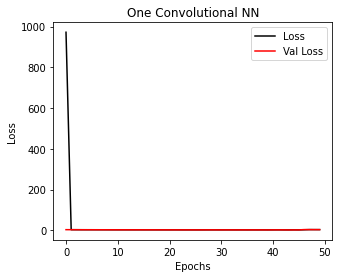

In [140]:
plot_nn_performace( 'One Convolutional NN' )

## 4.2. Two Convolutional NN Train

In [30]:
history = cnn.fit( train_img, epochs=50, validation_data=valid_img, batch_size=32 )

In [21]:
print( history.history, file=open( 'TwoConvolutionalStatus.txt', 'a' ) )

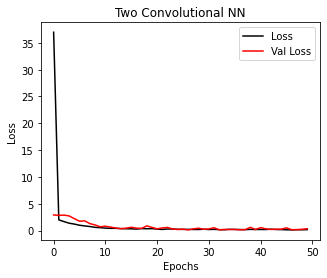

In [22]:
plot_nn_performace( 'Two Convolutional NN' )

In [25]:
acc = cnn.evaluate(test_img)
cnn.save_weights('model_100.h5')

98/98 [==============================] - 4s 45ms/step - loss: 0.3406 - accuracy: 0.9177


In [28]:
print(f'Model Accuracy: {np.round( acc[1], 3 )}\nModel Loss: {np.round( acc[0], 3 )}')

Model Accuracy: 0.918
Model Loss: 0.341


## 4.3. Model Prediction

In [31]:
pred = cnn.predict(test_img)
predmax = np.argmax( pred, axis=1 )

In [52]:
labels = test_img.class_indices
labels = dict( (v, k) for k, v in labels.items() ) # Change Labels Position
l_pred = [labels[k] for k in predmax]

In [63]:
print(f"Model Predict Fruit: {l_pred[200:201][0]}\nReal Class Indice: {test_img.classes[200:201][0]}\nClass for Apple Braeburn: {test_img.class_indices['apple_braeburn_1']}")

Model Predict Fruit: apple_braeburn_1
Real Class Indice: 1
Class for Apple Braeburn: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


,Labels,Percentages
0,apple_6,1.0


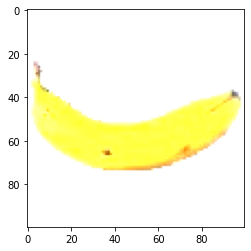

In [138]:
model_predict( '../test_img/imagem0.jpg', cnn ) # Model dont Trained for Classify Bananas

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


,Labels,Percentages
0,eggplant_violet_1,0.940451


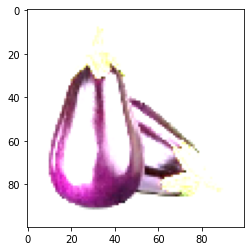

In [136]:
model_predict( '../test_img/imagem3.jpg', cnn )